# Week 3 - classfication
This notebook is a reference to the notebook provided by *Hands on Machine Learning* by Geron Aurelien.
1. Load dataset
2. Training a binary classifier
3. Performacne mesures
4. Multiclass classification
5. Error analysis
6. Multilabel classification
7. Multioutput classification


# Setup

Define the default font sizes to make the figures prettier:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# 1. Load dataset

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

Visualize the first sample

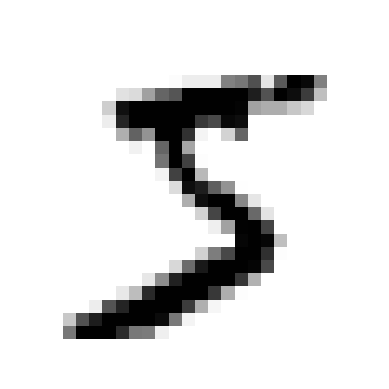

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

Visualize the first 100 samples

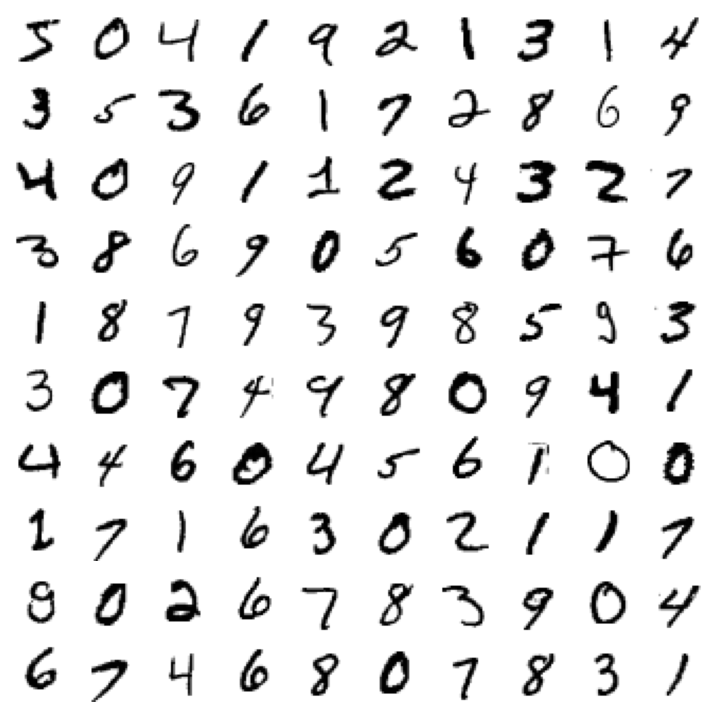

In [9]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.show()

Split data into training and testing sets

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 2. Training a binary classifier

In [11]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [12]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, loss='log_loss')
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(loss='log_loss', random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# 3. Performance measures

## Measuring accuracy using cross-validation

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95995, 0.9695 , 0.96745])

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred) # tn, fp, fn, tp
cm

array([[53870,   709],
       [ 1353,  4068]])

## Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 4068 / (709 + 4068)

0.8515804898471844

In [22]:
recall_score(y_train_5, y_train_pred)  # == 4068 / (1353 + 4068)

0.750415052573326

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7978034908805648

## Precision/Recall Trade-off

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores # can be negative or positive

array([1780.22115429])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [26]:
y_some_digit_pred

array([ True])

In [27]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

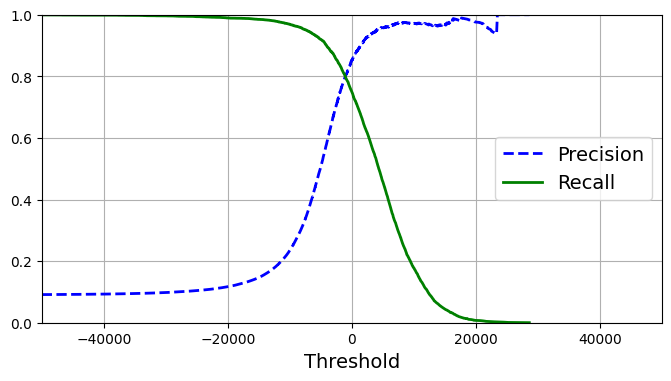

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

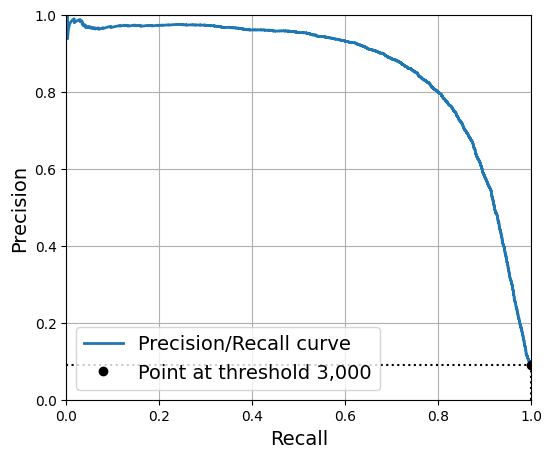

In [31]:
plt.figure(figsize=(6, 5))

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [32]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

1372.1165469629132

In [33]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9001221001221001

In [35]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.6799483490130972

## The ROC Curve

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

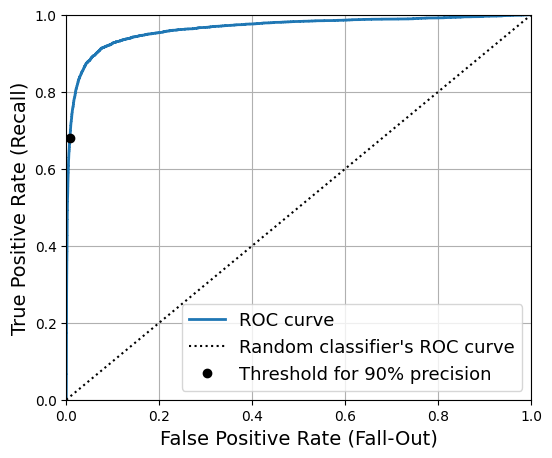

In [37]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9650798064853275

(take a break and run the following four cells)
# 4. Multiclass classification

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)  # y_train, not y_train_5

KNeighborsClassifier()

In [40]:
knn_clf.predict([some_digit])

array(['5'], dtype=object)

In [41]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9676 , 0.9671 , 0.96755])

In [42]:
y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

# 5. Error analysis

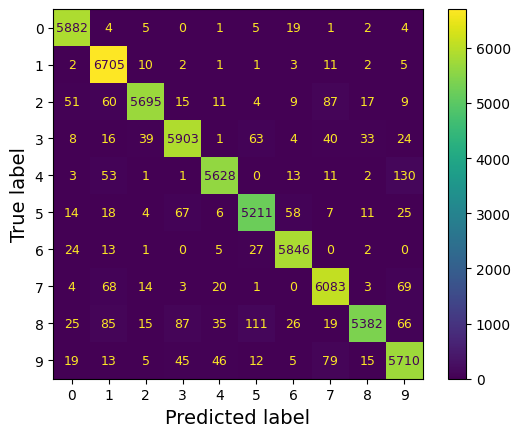

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

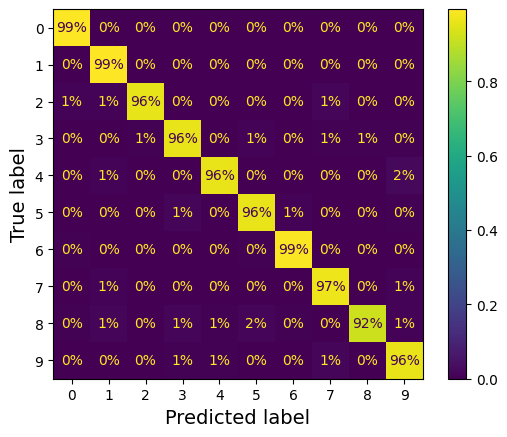

In [ ]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

In [ ]:
cl_a, cl_b = '8', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

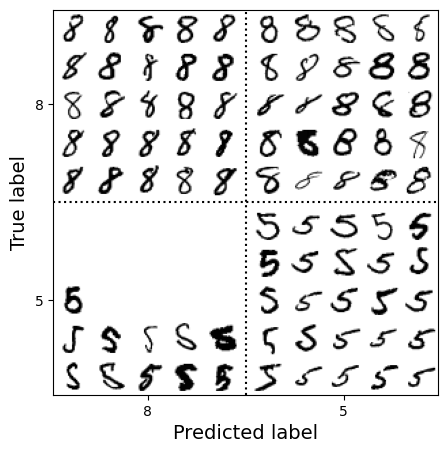

In [ ]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# 6. Multilabel classification

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 7. Multioutput classification

In [ ]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise # image with noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train # the original image
y_test_mod = X_test

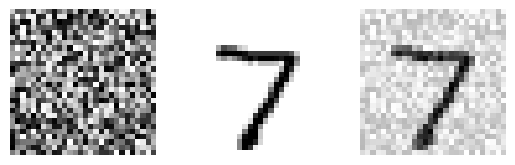

In [ ]:
plt.subplot(131)
plot_digit(noise[0]) # noise
plt.subplot(132)
plot_digit(y_test_mod[0]) # original image
plt.subplot(133)
plot_digit(X_test_mod[0]) # noise image

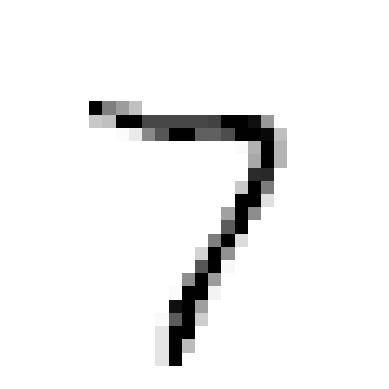

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)



---



# In-class exercise



1. Load dataset
2. Training binary classifiers
3. Performacne mesures
4. Visualization



#  1. Load dataset(10%)
Please upload both the train and test datasets to Colab, and randomly print out one picture of a cat and one picture of a dog.

"Cats and Dogs image classification
https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification"

# 2. Training binary classifiers
Please use Logistic Regression, KNN, and Naive Bayes respectively to build models.



###Logistic Regression(15%)

###KNN(15%)

###Naive Bayes(15%)

# 3. Performacne mesures
Please analyze the Accuracy, Precision, and Recall of the Logistic Regression, KNN, and Naive Bayes models separately.


###Logistic Regression(10%)

###KNN(10%)

###Naive Bayes(10%)

# 4. Visualization
Plot line charts for the Accuracy, Precision, and Recall of the three models.


###Logistic Regression(5%)

###KNN(5%)

###Naive Bayes(5%)